
### This notebook introduces the basic usage of the exoInfoMatrix class, used to make predictions about the precision of planetary parameters. For a more specific example aimed at predictions of planet candidates, see the TOIs notebook.

In [1]:

# Import the class and lightkurve
from pepita import exoInfoMatrix
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
import ldtk.filters as filters
from ldtk import LDPSetCreator, BoxcarFilter, TabulatedFilter
from astropy.time import Time
import astropy.units as u

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.



### Now, suppose you want to make predictions for TOI-1601



Then we have two situations, suppose we have made observations with 1800s cadence (the case for TOI-1601). Then we can

- Make a Markov Chain Monte Carlo fit to these observations to obtain some planetary and orbital parameters
- Or find the maximum likelihood set of parameters for the observations.

For our practical case, we will download the 1800s cadecence lightcurve that is available and use it to obtain the mean error in the flux measurements. This will later be used to estimate the errors in measurements made using different cadences.

For the planetary parameters we'll use the values reported in the NASA Exoplanet Archive but we could've done any of the above too.

In [3]:

search = lk.search_lightcurve("TOI-1601", mission="TESS")
print("We will use ligthcurves from the 'TESS-SPOC' pipeline")
search

We will use ligthcurves from the 'TESS-SPOC' pipeline


#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector,2019,DIAMANTE,1800,139375960,0.0
1,TESS Sector 18,2019,TESS-SPOC,1800,139375960,0.0
2,TESS Sector 18,2019,QLP,1800,139375960,0.0
3,TESS Sector 18,2019,CDIPS,1800,139375960,0.0


In [4]:

# Filter to get only the TESS-SPOC results

mask = [author == "TESS-SPOC" for author in search.author]
search[mask]

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 18,2019,TESS-SPOC,1800,139375960,0.0


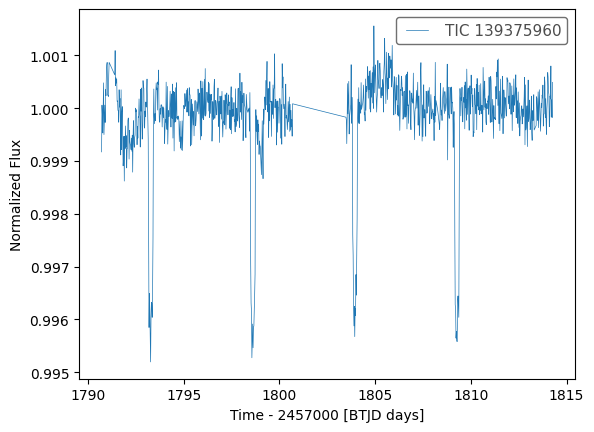

In [5]:

# Now download the ligthcurve

plt.close()

# We have to normalize so that the lightcurve is centred around 0 and flux errors are scaled properly
lc = search[mask].download().remove_nans().normalize().remove_outliers(sigma_lower=np.inf)

fig, ax = plt.subplots()
lc.plot(ax=ax)
plt.show()

In [6]:

# The median error of the flux measurements is

sigma1800s = float(np.median(lc.flux_err.value))


### IMPORTANT: It is required that the errors of the measurements are those corresponding to a scaling of the flux measurements such that the value of the flux outside the transits is 1 (that is, the lightcurve and the errors in the flux measurement must be normalized).

In [7]:

# From the exoplanet archive (https://exoplanetarchive.ipac.caltech.edu/overview/TOI-1601) (Rodriguez et al. 2021) we have

period = 5.331751 # [days]
period_sd = 0.000011 # error of period value [days]
t0 = 2458990.55202 # transit mid-point [Barycentric Julian Date (BJD)]
t0_sd = 0.00081 # error of transit mid-point value [BJD]
ror = 0.05827 # radius ratio between planet and star
ror_sd = 0.00071 # error of radius ratio
b = 0.136 # the impact parameter
b_sd = 0.13 # error of impact parameter
m_star = 1.517 # mass of the star [solar mass]
m_star_sd = 0.053 # error of stellar mass
r_star = 2.186 # radius of the star [solar radii]
r_star_sd = 0.074 # error of stellar radius
teff = 5948 # effective temperature of the star [K]
teff_sd = 89 # error of effective temperature [K]
logg = 3.940 # stellar surface gravity [cm/s^2]
logg_sd = 0.025 # error of stellar surface gravity [cm/s^2]
z = 0.329 # metallicity [Fe/H]
z_sd = 0.083 # error in metallicity [Fe/H]

In [8]:

# Since there are no values for the limb-darkening parameters we estimate them. See the TOIs notebook for a more in-depth procedure

filt = filters.create_tess()

sc = LDPSetCreator(teff=(teff, teff_sd), logg=(logg, logg_sd), z=(z, z_sd), filters=[filt])

ps = sc.create_profiles(nsamples=1000)

qc, qe = ps.coeffs_qd(do_mc=True)

u1 = qc[0][0] # quadratic limb-darkening coefficient 1
u2 = qc[0][1] # quadratic limb-darkening coefficient 2


Suppose we want to see what would happen to the precision of the radius ratio if we make observations with 20s cadence during 40 days

In [9]:

# Supposing no interruptions during the 40 days our array of timestamps would be

t = np.arange(0, 27, 20 / (3600 * 24))

# With 0 corresponding to when we start observations. Now, imagine we start the observations on the 15th of December 2022. That means day 0 in JD (approximately ~BJD by max error of about ~8 mins) is

day0 = Time('2022-12-15T00:00:00').jd

# So our timestamps are

t = t + day0

t

array([2459928.5       , 2459928.50023148, 2459928.50046296, ...,
       2459955.49930556, 2459955.49953704, 2459955.49976852])

In [10]:

# Now we can initalize the information analysis class. The oversample parameter measures how many points are used in each bin when binning the lightcurve to the needed cadence

infomatrix = exoInfoMatrix(exptime=20, oversample=1000)

# Then we set the values for the fiducial model

infomatrix.set_data(
    time_array = t,
    period_val = period,
    t0_val = t0,
    ror_val = ror,
    b_val = b,
    u1_val = u1,
    u2_val = u2,
    m_star_val = m_star,
    r_star_val = r_star
)

# And we can use the errors of our current values as priors

infomatrix.set_priors(
    period_prior = period_sd,
    t0_prior = t0_sd,
    ror_prior = ror_sd,
    b_prior = b_sd,
    m_star_prior = m_star_sd,
    r_star_prior = r_star_sd,
)

# Now, we approximate the errors in 20s cadence measurements by scaling the 1800s mean errors

sigma20s = sigma1800s * np.sqrt(1800/20)

# And we get the covariance matrix

covmatrix = infomatrix.eval_cov(sigma = sigma20s)

In [11]:

# If we look at the legend

infomatrix.legend

# t is not included in the covariance matrix, so if we shift all variables to one value less we see that the row and column corresponding to the radius ratio is the second one. Therefore, the variance predicted for the radius ratio is

{'t': 0,
 'period': 1,
 't0': 2,
 'ror': 3,
 'b': 4,
 'u1': 5,
 'u2': 6,
 'm_star': 7,
 'r_star': 8}

In [12]:

predict_ror_var = covmatrix[2, 2]

# And the standard deviation, which is our predicted error is

predict_ror_sd = np.sqrt(predict_ror_var)

# We can print the predictions for all variables too

for i, value1 in enumerate(["period", "t0", "ror", "b", "u_star1", "u_star2", "m_star", "r_star"]):
    for j, value2 in enumerate(["period", "t0", "ror", "b", "u_star1", "u_star2", "m_star", "r_star"]):
        if value1 == value2:
            std = np.sqrt(np.abs(covmatrix[i,j]))
            print(f"{value1} sd = {std}")

period sd = 5.064056611849475e-06
t0 sd = 0.0007535295007894165
ror sd = 0.0004713626767968396
b sd = 0.11241866890854353
u_star1 sd = 0.17692205571293404
u_star2 sd = 0.3069646421996968
m_star sd = 0.05076611684564301
r_star sd = 0.04071672706234801



### So we predict that by obtaining 27 days (~1 TESS sector) of 20s cadence observations we can improve the precision in the radius ratio by

In [13]:
improv = ( 1 - predict_ror_sd / ror_sd ) * 100

print(f"{improv:.1f}%")

33.6%
